<a href="https://colab.research.google.com/github/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/blob/main/BasicCNNAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Convolutional Neural Network AutoEncoder notebook**

# **cell for installing a module or package**

# **Necessary Import for our notebook**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav
from IPython.display import Audio
#from sound import sound

## **Function to convert signal audio vector to tensor**

In [ ]:
def signal2pytorch(x):
   #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
   #Argument x: a 1-d signal as numpy array
   #input x[batch,sample]
   #output: 3-d Tensor X for conv1d input.
   #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
   X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
   if len(x.shape)==1: #mono:
      X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
   X=torch.from_numpy(X)
   X=X.type(torch.Tensor)
   X=X.permute(1,0,2)  #make batch dimension first
   return X

# **Convolution autoencoder class consist of encoder,decoder,and forward propogation function**

In [ ]:
class Convautoenc(nn.Module):
   def __init__(self):
      super(Convautoenc, self).__init__()
      #Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
      self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

      #Synthesis filter bank:
      self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

   def encoder(self, x):
      #Analysis:
      x = self.conv1(x)
      y = torch.tanh(x)
      return y
      
   def decoder(self, y):
      #Synthesis:
      xrek= self.synconv1(y)
      return xrek
      
   def forward(self, x):
      y=self.encoder(x)
      #y=torch.round(y/0.125)*0.125
      xrek=self.decoder(y)
      return xrek

# **Loading of Track16.wav file from github**

In [ ]:
!wget https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
print('Track16.wav loaded')

--2020-10-27 19:31:26--  https://raw.githubusercontent.com/param1707/-Optimizing-a-neural-network-filter-bank-for-musical-instrument-classification-/main/Track16.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790336 (1.7M) [audio/wav]
Saving to: ‘Track16.wav’

Track16.wav         100%[===================>]   1.71M  --.-KB/s    in 0.1s    

2020-10-27 19:31:26 (15.4 MB/s) - ‘Track16.wav’ saved [1790336/1790336]

Track16.wav loaded


# **Processing and training of audio data with left channel**

In [ ]:
filename = 'Track16.wav'
fs, audio = wav.read(filename)

#make it mono left channel
audio0=audio[:,0] 

#make it mono right channel
audio1=audio[:,1] 

#normalization of left audio channel
audio0=audio0*1.0/np.max(np.abs(audio0))
print("audio0.shape=", audio0.shape)

#normalization of right audio channel 
audio1=audio1*1.0/np.max(np.abs(audio1))
print("audio1.shape=", audio1.shape)

#Convert to pytorch format, (training with left audio channel)
X=signal2pytorch(audio0)    

print("Generate Model:")
model = Convautoenc()

print("Def. loss function:")
loss_fn = nn.MSELoss()

# It is an unsupervised training so there is no target signal,we will use input signal for getting target values.
Ypred=model(X)

#length of the signal at the output of the network.
outputlen=len(Ypred[0,0,:]) 
print("outputlen=", outputlen)

#the target signal with same length as model output
Y=X[:,:,:outputlen]  

print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)

print("Y.type()=", Y.type())


learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred=model(X)
#Ypred=Ypred.detach()
print("Ypred=", Ypred)

audio0.shape= (447573,)
audio1.shape= (447573,)
Generate Model:
Def. loss function:
outputlen= 447490
Input X.shape= torch.Size([1, 1, 447573])
Target Y.shape= torch.Size([1, 1, 447490])
Target Y= tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -4.5912e-05,
           4.5912e-05, -4.5912e-05]]])
Y.type()= torch.FloatTensor
Ypred= tensor([[[0.0034, 0.0069, 0.0056,  ..., 0.0072, 0.0029, 0.0062]]],
       grad_fn=<SqueezeBackward1>)


In [ ]:
losses = np.zeros(1999)
for epoch in range(2000):
          Ypred=model(X)
          loss=loss_fn(Ypred, Y)
          losses[epoch - 1] = loss.item()
          if epoch%10==0:
             print(epoch, loss.item())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

0 0.03495403379201889
10 0.033849090337753296
20 0.031854297965765
30 0.029526237398386
40 0.027623824775218964
50 0.02600894309580326
60 0.02440592460334301
70 0.022868193686008453
80 0.021524103358387947
90 0.02040822245180607
100 0.019474053755402565
110 0.01865166239440441
120 0.017889639362692833
130 0.017162231728434563
140 0.016459207981824875
150 0.01577514037489891
160 0.01510612666606903
170 0.014450875110924244
180 0.013811488635838032
190 0.013192675076425076
200 0.012599884532392025
210 0.012037569656968117
220 0.011508366093039513
230 0.011012997478246689
240 0.010550799779593945
250 0.010120122693479061
260 0.009718711487948895
270 0.00934404693543911
280 0.0089936638250947
290 0.008664949797093868
300 0.008355781435966492
310 0.008064267225563526
320 0.00778880575671792
330 0.007528100628405809
340 0.007281102705746889
350 0.007046987768262625
360 0.006825087126344442
370 0.006614857818931341
380 0.006415811832994223
390 0.006227496545761824
400 0.006049439776688814
410

In [ ]:
print(range(epoch))
print(losses)

range(0, 1999)
[0.03485594 0.03476189 0.0346689  ... 0.00115316 0.00115272 0.00115228]


# **Graph with the number of epochs vs the training loss**

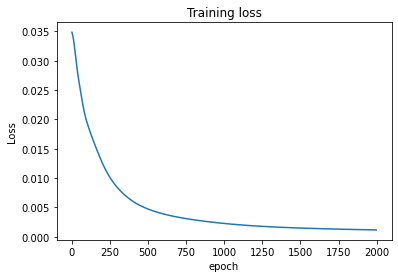

In [ ]:
plt.figure(1)

plt.plot(range(epoch),losses)
plt.title('Training loss');
plt.xlabel('epoch'); plt.ylabel('Loss');
plt.show()

# **Testing of the model with Right Channel**

In [ ]:
#Convert to pytorch format (testing with right audio channel)
X=signal2pytorch(audio1)

# Make Predictions based on the obtained weights, on right audio channel(test audio)
predictions=model(X) 
predictions=predictions.detach()
predictions=np.array(predictions)

plt.plot(np.array(X[0,0,:]))
plt.plot(predictions[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal, Right audio channel')
plt.xlabel('Sample')
plt.show()

xrek=predictions[:,0,:]